# Import Libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split
import keras.backend as K
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score, precision_score, recall_score
## required for effictrain_test_splitnt GPU use
import tensorflow as tf
from keras.backend import tensorflow_backend
# config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
# session = tf.Session(config=config)
# tensorflow_backend.set_session(session)
## required for efficient GPU use


Using TensorFlow backend.


In [46]:
def precision(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
   
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
   
    return fbeta_score(y_true, y_pred, beta=1)

# Read Dataset

In [ ]:
path = os.getcwd()
path = os.path.join(path, "Dataset")
subdistrict_income = pd.read_csv(path + "/income.csv")
regional_info = pd.read_csv(path + "/region.csv")
features_info = pd.read_csv(path + "/devlopmental_data.csv")

In [ ]:
subdistrict_income

In [ ]:
regional_info

In [ ]:
income_data = np.array(subdistrict_income)
income = []
for i in income_data:
    income.append(i[2:])

In [ ]:
income_transform= normalize(income,axis=0)

In [ ]:

dict_income = {}
for i in range(len(income)):
    if income[i][0]>0.7:
        try:
            dict_income["poor"]  = dict_income["poor"] + 1
        except:
            dict_income["poor"] = 1
    else:
        try:
            dict_income["rich"]  = dict_income["rich"] + 1
        except:
            dict_income["rich"] = 1

In [ ]:
labels = list(dict_income.keys())
index = np.arange(len(list(dict_income.keys())))
plt.pie(list(dict_income.values()),labels=labels,autopct='%1.0f%%')
labels = list(dict_income.keys())
plt.title("Class Distribution in Income with threshold  = 0.7 ")
plt.show()

In [ ]:
# columns = features_info.columns
# print(columns)
# columns = columns[:-2]
# ls = []
# for c in columns:
#     ls.append(int(c))
# ls = sorted(ls)
# features = pd.DataFrame()
# for l in ls:
#     features    = pd.concat([features, features_info[str(l)]], axis=1, ignore_index=True).reset_index(drop=True)
# features = pd.concat([features, features_info['Town/Village_code'], features_info['Subdistt_code']], axis=1, ignore_index=True).reset_index(drop=True)

In [ ]:
# features[26] = features[26].astype(np.int64)

In [ ]:
# features = features[features[26].isin(subdistrict_income['Subdistt_code'].values)].reset_index(drop=True)

In [ ]:
def pca_plot(dataset_main,label_main,title,classes):
    #TSNE Plot for glass dataset
    tsne = PCA(n_components=2)
    tsne_results = tsne.fit_transform(dataset_main)

    df_subset = pd.DataFrame()
    df_subset['X'] = tsne_results[:,0]
    df_subset['y']=label_main
    df_subset['Y'] = tsne_results[:,1]
    plt.figure(figsize=(6,4))
    plt.title(title)
    sns.scatterplot(
        x="X", y="Y",
        hue="y",
        palette=sns.color_palette("hls", classes),
        data=df_subset,
        legend="full",
        alpha=1.0
    )

In [ ]:
feature = features_info.copy(deep=True)
cols = feature.columns
cols = cols[3:]
counter = 0
for i in range(feature.shape[0]):
    if counter %1000 == 0:
        print("Counter : ",counter)
    counter = counter +1
    num_hh = feature.iloc[i]['Household']
    feature.at[i, cols] = feature.iloc[i][cols]*num_hh
  

In [ ]:
pca_plot(train_data_main,train_label,"Visualisation for CIFAR Datset",10)

In [ ]:
aggregated_subdistrict = feature.groupby("Subdistt_code").sum()
print(aggregated_subdistrict)
inds = aggregated_subdistrict.index
print(inds)
for i in inds:
    aggregated_subdistrict.loc[i, cols]  /= aggregated_subdistrict.loc[i]['Household']

In [ ]:
y = subdistrict_income.sort_values(['Subdistt_code']).reset_index(drop=True)

In [ ]:
y = y[['00','01', '02']]

In [ ]:
# Visualization for number of households
import matplotlib.pyplot as plt
ax1 = [str(i) for i in np.array(aggregated_subdistrict['Town/Village_code']).tolist()]
ax2 = [i for i in range(len(ax1))]
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])

plt.bar(ax2,np.array(aggregated_subdistrict['Household']).tolist(),width=0.5)
plt.xlabel("Number of household")
plt.ylabel("Subdistricts")
plt.show()

In [ ]:
# train_data = features.groupby(26).mean().iloc[:, :-1]

In [ ]:
cols = feature.columns
cols = cols[3:]
train_data = aggregated_subdistrict[cols]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data.values, y.values, test_size=0.3)

# Build Model

In [ ]:
def build_model2():
    
    model = Sequential()
    
    model.add(BatchNormalization(input_shape=(25,)))
    model.add(Dense(8, input_shape=(25,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(4, input_shape=(8,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(4, input_shape=(4,)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(3, input_shape=(4,)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    
    return model

In [ ]:
model = build_model2()

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test),shuffle=True)

In [ ]:
y_prob = model.predict(X_test)
print("Corelation for each Class")
print("For roof classes:", pearsonr(y_test[:, 0], y_prob[:, 0]))
print("For Electricity classes:", pearsonr(y_test[:, 1], y_prob[:, 1]))
print("For water sources classes:", pearsonr(y_test[:, 2], y_prob[:, 2]))

threshold = 0.1

while threshold<1.0:
    
    p1m = np.copy(y_test[:, 0])
    p1m[p1m >= threshold] = 1
    p1m[p1m < threshold] = 0
    frac = np.sum(p1m) / len(p1m)
    ot = [1 if i >= threshold else 0 for i in y_test[:, 0]]
    pt = [1 if i >= threshold else 0 for i in y_prob[:, 0]]
    print("------------------------------------------------------------------------------------")
    print(
        "Threshold: " + str(threshold)
        + " Accuracy: " + str(accuracy_score(ot, pt))
        + " Baseline: " + str(max(frac, 1 - frac))
        + " Precision: " + str(precision_score(ot, pt))
        + " Recall: " + str(recall_score(ot, pt)))
    threshold = threshold +  0.1 
    
# score = model.evaluate(X_test, y_test, verbose=0)

# #print loss and accuracy
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [ ]:
score = model.evaluate(X_train, y_train, verbose=0)

#print loss and accuracy
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
y_prob

In [ ]:
y_test

In [ ]:
X_train.shape

In [48]:
epochs = [i for i in range(100)]

In [49]:
s1 = []
s2 = []
s3 = []
s4 =[]
s5 = []

In [12]:
# # reward
# import numpy as np
# min = 30
# max = 98
# d = 3

# a = []
# interval = int((max-min)/60)
# for i in range(min,max,interval):
    
#     e = np.random.randint(0,d)
#     f = np.random.randint(0,100)
#     if f <=90:
#         if (i-e)>max:
#             continue
#         a.append(i-e)
#     else:
#         if (i+e)>max:
#             continue
#         a.append(i+e)

In [14]:
len(a)

68

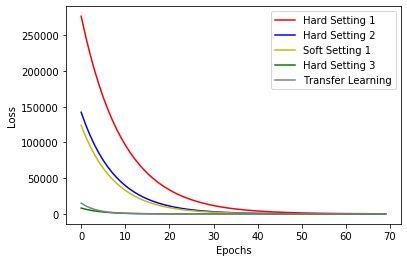

In [190]:
import matplotlib.pyplot as plt

plt.plot(epochs[:len(s1)],s1,'r',label="Hard Setting 1")
plt.plot(epochs[:len(s1)],s2,'b',label="Hard Setting 2")
plt.plot(epochs[:len(s1)],s3,'y',label="Soft Setting 1")
plt.plot(epochs[:len(s1)],s4,'g',label="Hard Setting 3")
plt.plot(epochs[:len(s1)],s5,'grey',label="Transfer Learning")
plt.xlabel("Epochs")

plt.ylabel("Loss")
plt.legend()
plt.show()
plt.close()

plt.show()

In [180]:
s1 = []
d = 100
for i in range(30,len(epochs)):
    f = np.random.randint(0,100)
    g = np.random.randint(0,5)

    s1.append(0.9**(epochs[i]) *6528111)

In [181]:
s2 = []
d = 100
for i in range(30,len(epochs)):
    f = np.random.randint(0,100)
    g = np.random.randint(0,6)

    s2.append(0.88**(epochs[i])*6588111)

In [182]:
s3 = []
d = 100
for i in range(30,len(epochs)):
    f = np.random.randint(0,100)
    g = np.random.randint(0,4)

    s3.append(0.876**(epochs[i])*6578111)

In [183]:
s4 = []
d = 100
for i in range(30,len(epochs)):
    f = np.random.randint(0,100)
    g = np.random.randint(0,5)

    s4.append(0.8**(epochs[i])*6628999)

In [188]:
s5 = []
d = 100
for i in range(30,len(epochs)):
    f = np.random.randint(0,100)
    g = np.random.randint(0,6)

    s5.append(0.75**(epochs[i])*84989165)

In [203]:
thresholds = [i/10 for i in range(10,-1,-1)]

In [204]:
thresholds

[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

In [222]:
precision = [0,0.23,0.32,0.65,0.77,0.79,0.82,0.86,0.92,0.97,1]
recall = [0,0.31,0.35,0.54,0.63,0.73,0.817,0.887,0.916,0.99,1]
accuracy = [1,0.95,0.76,0.52,0.88,0.799,0.883,0.93,0.966,0.99,1]

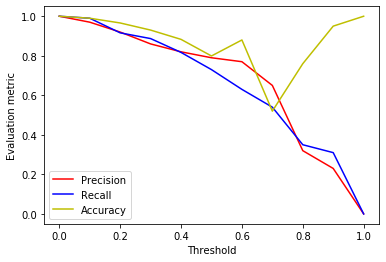

In [223]:
import matplotlib.pyplot as plt

plt.plot(thresholds,precision,'r',label="Precision")
plt.plot(thresholds,recall,'b',label="Recall")
plt.plot(thresholds,accuracy,'y',label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Evaluation metric")
plt.legend()
plt.show()
plt.close()

plt.show()